# **Tensorflow Subclassing and Custom Loop**

Import Libraries

In [46]:
import tensorflow as tf
from keras import layers, metrics, losses
from keras.datasets import mnist

###Multiclass Classification task on Mnist dataset.

First, let's load and visualize the dataset

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalization

In [48]:
x_train.shape

(60000, 28, 28)

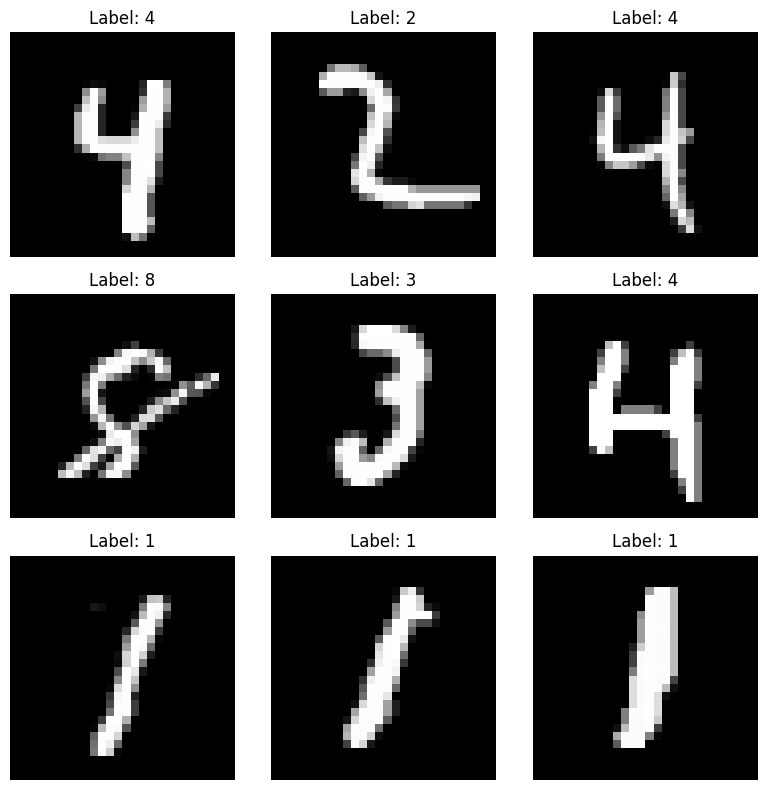

In [49]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
for i in range(9):
  random_index = np.random.randint(0, len(x_train))
  image = x_train[random_index]
  label = y_train[random_index]
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')
plt.tight_layout()
plt.show()


In [50]:
# If you want to work with images add the channel dimension
#x_train = x_train[..., tf.newaxis]
#x_test = x_test[..., tf.newaxis]
#x_train.shape

Let's define our model by extending the base class ```Model``` provided by Keras.

2 key elements:
- **Constructor**: define attributes, layers and every characteristic of the model
- **call function**: It defines the operation that the model execute when it is colled for inference (e.g. in the forward pass)  

In [51]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(10)

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        return self.dense2(x)

# Create an instance of the model
model = MyModel()

# Invoke the Call function (result will be the activations of the last dense layer)
model(tf.random.normal((1, 28, 28)))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.51978856, -1.4806361 , -0.8978178 , -0.86791015,  1.1448257 ,
        -1.0020833 , -0.49600184,  0.04873192,  0.679409  ,  0.53839004]],
      dtype=float32)>

Let's define a custom loss function by extending the base class ```Loss``` provided by Keras.

In [52]:
# Definisci una funzione di perdita custom
class SparseCategoricalCrossentropyCustom(losses.Loss):
    def call(self, y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=10)
        loss = -tf.reduce_sum(y_true * tf.math.log(tf.nn.softmax(y_pred) + 1e-10), axis=1)
        return tf.reduce_mean(loss)

Let's define a custom metric function by extending the base class ```Metric``` provided by Keras.

Key elements:
- **constructor**: it might contain metric variables, counters, scaling factors.
- **update state**: called after each batch
- **result**: called to retreive the **current** value of the metric
- **reset_state**: called at the end of each epoch

It is intended as cumulative: collect the results of each batch during traininf loop, and than aggregate!

**NOTE:** ```add_weight``` <ins>when used in Metrics class it doesn't create trainable weights</ins>. It is used to create optimized version of a variable that can be treated more efficiently. Out of the Metrics context, it is usually called to create trainable weights.  

In [53]:
# Definisci metriche custom
class AccuracyCustom(metrics.Metric):
    def __init__(self, name='accuracy_custom', **kwargs):
        super(AccuracyCustom, self).__init__(name=name, **kwargs)
        self.accuracy = self.add_weight(name='accuracy', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        matches = tf.equal(tf.cast(y_true, tf.int64), y_pred)
        self.accuracy.assign_add(tf.reduce_sum(tf.cast(matches, tf.float32)))
        self.total.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.accuracy / self.total

    def reset_states(self):
        self.accuracy.assign(0)
        self.total.assign(0)

### Managing Data
The `tf.data.Dataset.from_tensor_slices` function in TensorFlow creates a `Dataset` object from a set of data (arrays, tensors, or any compatible sequence of data). This function "slices" the input along the first dimension, creating a data structure that can generate mini-batches for training.

Key concepts:

1. **Input**: The function can take arrays of data such as NumPy arrays, TensorFlow tensors, or lists. If there are multiple inputs, they must have the same length along the first dimension, as they will be paired element by element.
  
2. **Output**: It creates a dataset containing individual elements "sliced" along the first dimension. For example, if you provide an array with dimensions `(60000, 28, 28)` (like `x_train` in the MNIST dataset), `from_tensor_slices` will create a dataset with 60,000 samples, each of shape `(28, 28)`.

3. **Common Uses**: This function is useful for creating datasets compatible with training that can be manipulated with methods such as `.batch()`, `.shuffle()`, and `.repeat()` to build custom data pipelines.

**Long story short**: Easily create iterable of batches and apply all the needed preprocessing operations.

In [54]:
epochs = 5
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [55]:
# Instantiate everything you need to train the model
loss_fn = SparseCategoricalCrossentropyCustom()
train_acc_metric = AccuracyCustom()
val_acc_metric = AccuracyCustom()

optimizer = tf.keras.optimizers.Adam()
model = MyModel()

## Customized Training Loop
#### What appens in the `fit()` function


Key lines of code:
```python
grads = tape.gradient(loss_value, model.trainable_weights)
optimizer.apply_gradients(zip(grads, model.trainable_weights))
```

1. **Compute Gradients** (`tape.gradient()`):
   - Here, `tape.gradient` calculates the gradient of `loss_value` with respect to the model’s trainable weights.
   - `tape` is a `tf.GradientTape` context that records all operations on tensors watched during the forward pass, allowing us to compute gradients for backpropagation.
   - `loss_value` is the loss calculated for the current batch.
   - `model.trainable_weights` represents all weights in the model that need to be updated during training.
   - The result, `grads`, is a list of gradients (one per trainable weight in the model) that shows how each weight should be adjusted to reduce the loss.

2. **Apply Gradients** (`optimizer.apply_gradients()`):
   - This line uses the optimizer (e.g., Adam, SGD) to update the model's weights based on the gradients calculated.
   - `zip(grads, model.trainable_weights)` pairs each gradient with its corresponding weight, creating a list of `(gradient, weight)` tuples.
   - `optimizer.apply_gradients` then updates each weight by subtracting a fraction of the gradient (the learning rate determines this fraction) to minimize the loss.
   
**Long story short**: In essence, this step updates the model’s parameters in the direction that should reduce the loss, following the rules of the specified optimizer.

In [56]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")

    # Trainig Loop
    for x_batch_train, y_batch_train in train_dataset:
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_acc_metric.update_state(y_batch_train, logits)
        print('=', end='')

    train_acc = train_acc_metric.result()
    print(f"\nEpoch {epoch + 1} Train Accuracy: {float(train_acc):.4f}")
    train_acc_metric.reset_states()

    # Validation Loop
    for x_batch_val, y_batch_val in test_dataset:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)

    val_acc = val_acc_metric.result()
    print(f"Epoch {epoch + 1} Validation Accuracy: {float(val_acc):.4f}")
    val_acc_metric.reset_states()



Epoch 1
Epoch 1 Train Accuracy: 0.8497
Epoch 1 Validation Accuracy: 0.9226

Epoch 2
Epoch 2 Train Accuracy: 0.9304
Epoch 2 Validation Accuracy: 0.9405

Epoch 3
Epoch 3 Train Accuracy: 0.9433
Epoch 3 Validation Accuracy: 0.9474

Epoch 4
Epoch 4 Train Accuracy: 0.9515
Epoch 4 Validation Accuracy: 0.9525

Epoch 5
Epoch 5 Train Accuracy: 0.9574
Epoch 5 Validation Accuracy: 0.9562


# Parametrized Custom Model

In [57]:
import tensorflow as tf
from keras import layers

# Define a custom model class inheriting from tf.keras.Model
class MyModel(tf.keras.Model):
    def __init__(self, mylayers: list, out_size: int, act):
        super(MyModel, self).__init__()
        self.flatten = layers.Flatten()

        # Create a list to store hidden layers
        self.hidden_layers = []
        # Loop through the specified neurons in `mylayers` to create hidden layers
        for neurons in mylayers:
            # Add a dense layer with the specified number of neurons and activation function
            self.hidden_layers.append(layers.Dense(neurons, activation=act))

        # Define the output layer with the number of units equal to out_size
        # Here we assume out_size represents the number of classes in the classification task
        self.output_layer = layers.Dense(out_size)

    def call(self, inputs):
        x = self.flatten(inputs)

        # Pass the flattened inputs through each hidden layer in sequence
        for layer in self.hidden_layers:
            x = layer(x)

        return self.output_layer(x)

# Create an instance of the model with specified parameters
model = MyModel(mylayers=[128, 64, 16], out_size=10, act='relu')

result = model(tf.random.normal((1, 28, 28)))

print(result)

tf.Tensor(
[[-0.6346771  -0.21130115  1.5758224  -0.153721    0.5675653   0.41883677
  -0.13659307 -0.6748707   0.8947159  -0.12220135]], shape=(1, 10), dtype=float32)


# Custom Layer

key elements:

- **SimpleDense Class**: This class defines a custom dense (fully connected) layer with a specified number of units (neurons).
- **Build Method**: This is called automatically on the first input pass to the layer to initialize the layer’s weights. `self.kernel` represents the weights, while `self.bias` represents the bias term.
- **Call Method**: Specifies the computation logic during the forward pass. Here, it multiplies the inputs by the weights (`self.kernel`) and adds the bias (`self.bias`), representing a classic fully connected layer.
- **Instantiation and Testing**:
  - The instance `linear_layer` is created with 4 units.
  - When `linear_layer` is called with an input of shape `(2, 2)`, the `build` method is automatically executed to create the weights.

**NOTE**: you can define any operations in the `call` function,  but <ins>be mindful of differentiability!</ins>

In [59]:
import tensorflow as tf
from keras.layers import Layer
from tensorflow import keras
import tensorflow.experimental.numpy as ops  # Using TensorFlow's experimental numpy ops for matmul

# Define a custom layer class `SimpleDense`, which inherits from `Layer`
class SimpleDense(Layer):
    def __init__(self, units=32):
        # Initialize the base class
        super().__init__()
        # Set the number of units (neurons) for this layer
        self.units = units

    # Build method to create the state of the layer (weights and biases)
    def build(self, input_shape):
        # Define and initialize the kernel (weights matrix)
        # `input_shape[-1]` is the size of the last dimension of the input, which matches the input features
        # `self.units` is the number of neurons in this layer, determining the output size
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),  # Shape of the weights matrix
            initializer="glorot_uniform",         # Weight initialization method
            trainable=True,                       # Marks this weight as trainable
            name="kernel",                        # Name of the weight for easier identification
        )

        # Define and initialize the bias vector
        # The bias has a shape matching the number of units in the layer
        self.bias = self.add_weight(
            shape=(self.units,),                  # Shape of the bias vector
            initializer="zeros",                  # Initialize bias to zero
            trainable=True,                       # Marks this bias as trainable
            name="bias",                          # Name of the bias for easier identification
        )

    # Call method defines the forward pass computation for the layer
    def call(self, inputs):
        # Calculate the layer output using a matrix multiplication between inputs and weights,
        # then add the bias term
        return ops.matmul(inputs, self.kernel) + self.bias

# Instantiate the custom dense layer with 4 units
linear_layer = SimpleDense(4)

# Call the layer on some input data, which will automatically call `build(input_shape)`
# and create the weights if they haven’t been created yet.
y = linear_layer(ops.ones((2, 2)))  # Passes a tensor of shape (2, 2) as input
print(y)

tf.Tensor(
[[-0.662874   -0.16512823  0.9126694   0.54519343]
 [-0.662874   -0.16512823  0.9126694   0.54519343]], shape=(2, 4), dtype=float32)
